## Data:

Shape: (316200, 6)

Columns:
- country : user country based on the IP address
- age : user age. Self-reported at sign-in step
- new_user : whether the user created the account during this session or had already an account and simply came back to the site
- source : marketing channel source
    - Ads: came to the site by clicking on an advertisement
    - Seo: came to the site by clicking on search results
    - Direct: came to the site by directly typing the URL on the browser
- total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
- converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions.

In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read the table
df = pd.read_csv("./conversion_project.csv")

# print some samples
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [ ]:
# 懶人包
plt.ion()
profile = ProfileReport(df, title="Pandas Profiling Report")
profile

In [9]:
# check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [10]:
# show descriptive statistics
# country, source屬於類別變數，敘述統計量只能統計連續變數
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


## Box plot
- 觀察連續的分佈
    - 針頭頂部：上邊界
    - 針頭底部：下邊界
    - 盒子底部：第一四分位數(Q1)
    - 盒子中部：第二四分位數(中位數，Q2)
    - 盒子頂部：第三四分位數(Q3)
    - 圓點：離群值 (與Q1, Q3 差距 >1.5xIQR時，視為離群值)
- Age
    - 大多數用戶介於 20~40之間 (min=17, q1=24, q2=30, q3=36)
    - 有兩個非常不合理的離群值 (age = 111, 120)
    - 右尾分布
- total_pages_visited
    - 大多數用戶介於 1~10之間 (min=1, q1=2, q2=4, q3=7)
    - 沒有較不合理的異常值
    - 右尾分布
- 是否處理離群值？
    - 只處理(age = 111, 120)這兩個樣本，屬於異常值
    - 其餘的離群值，我認為屬於可以幫助模型的離群值

<AxesSubplot:>

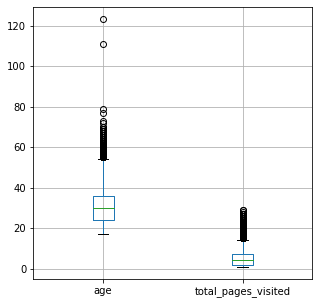

In [46]:
plt.figure(figsize=(5, 5))
df[["age", "total_pages_visited"]].boxplot(figsize=(5, 5))

### Histogram

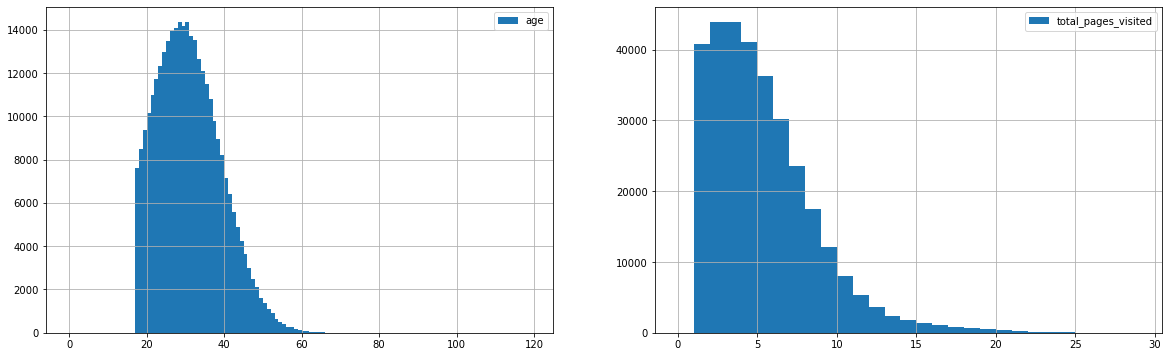

In [116]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))

# the histogram of the data
n, bins, patches = ax[0].hist(df[["age"]], bins=[1*i for i in range(120)], density=False, label="age")
n, bins, patches = ax[1].hist(df[["total_pages_visited"]], bins=[1*i for i in range(30)], density=False, label="total_pages_visited")

for i in range(2):
    ax[i].legend()
    ax[i].grid(True)

- 觀察連續變數: age, total_pages_visited
- age:
    -  右尾分布 (大部分資料落在20~40之間)
- total_pages_visited
    -  右尾分布 (大部分資料落在0~10之間)
    -  大多數用戶停留時間不長（不會瀏覽太多頁面

### Bar

0    0.967742
1    0.032258
Name: converted, dtype: float64


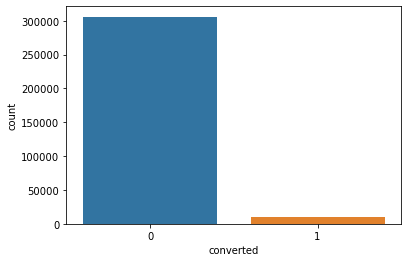

1    0.685465
0    0.314535
Name: new_user, dtype: float64


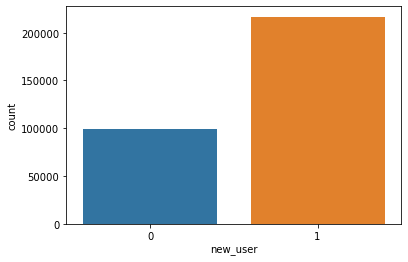

US         0.563226
China      0.242258
UK         0.153226
Germany    0.041290
Name: country, dtype: float64


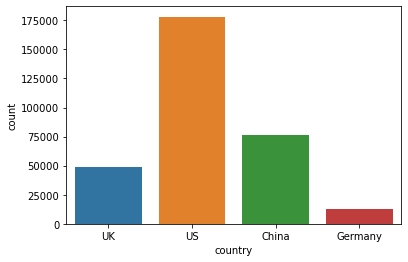

Seo       0.490323
Ads       0.280645
Direct    0.229032
Name: source, dtype: float64


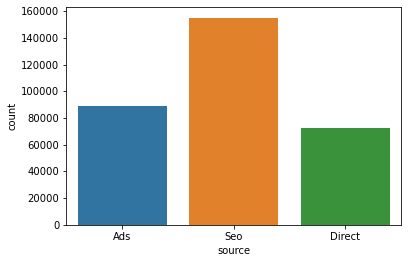

In [193]:
# target
sns.countplot(x ='converted', data = df) 
print(df.converted.value_counts()/df.shape[0])
plt.show() 

sns.countplot(x ='new_user', data = df) 
print(df.new_user.value_counts()/df.shape[0])
plt.show() 

# categorical data visualization
sns.countplot(x ='country', data = df)
print(df.country.value_counts()/df.shape[0])
plt.show() 

sns.countplot(x ='source', data = df) 
print(df.source.value_counts()/df.shape[0])
plt.show() 

- Target
    - 屬於umbalanced data比例大約 30:1 (正樣本大約只佔總資料3%)
- New user
    - 老用戶:新用戶 大約為 1:2
- Country
    - 總共有四種變數 UK, US, China, Germany, 其中以US站絕大多數
- Source
    - 總共有三種變數 Ads, Seo, Direct, 其中以 Seo站絕大多數

### one-hot encoding
- 做one-hot的原因：每個國家、來源視為獨立變數，若用label encoding對模型不利（會視彼此有相關，且有順序關係）
- one-hot並不是最好的作法，考慮到稀疏矩陣的問題（若一個變數對應的類別太多 (ex: 有100個國家)，做one-hot會變100x100的矩陣，會讓資料太稀疏）
- 其他的encoding方式：
    - Label encoding
    - Target / Mean Encoding
    - Count and Frequency encoding
    - ...
- Embedding
    - 可以讓模型做representation learning (將原始向量投影到適合的空間上)
    - CV & NLP 常用的作法
    - 適合用在 NN-based 的模型上

In [31]:
country_part = pd.get_dummies(df["country"], prefix="is")
source_part = pd.get_dummies(df["source"], prefix="is")

# concat dataframes
df_oh = pd.concat([df, country_part, source_part], axis=1)

# delete original columns
del df_oh["country"], df_oh["source"]

In [32]:
# check the dataframe
df_oh.head()

,age,new_user,total_pages_visited,converted,is_China,is_Germany,is_UK,is_US,is_Ads,is_Direct,is_Seo
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1


## 觀察變數之間的關係

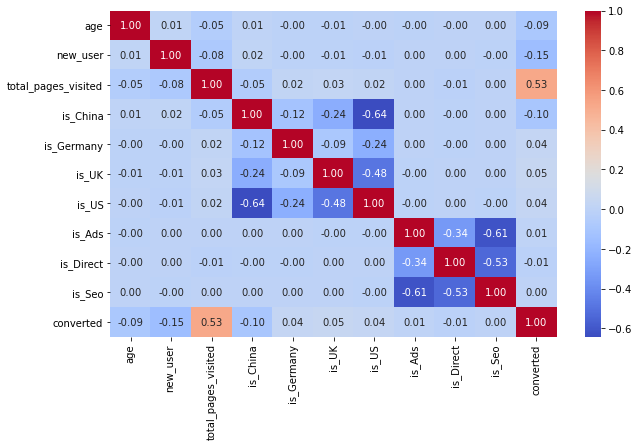

In [41]:
fig, ax = plt.subplots(figsize=(10,6))
g=sns.heatmap(df_oh[[c for c in df_oh.columns if c != "converted"] + ["converted"]
                   ].corr(),annot=True ,fmt=".2f", cmap="coolwarm", ax=ax)

### correlation matrix
- default method: 'pearson correlation'
- 初步判斷變數相關性
    - 1.00 完全相關
    - 0.70 ~ 0.99 高度相關
    - 0.40 ~ 0.69 中度相關
    - 0.10 ~ 0.39 低度相關
    - 0 ~ 0.10 微弱相關 or 無關
<br/>    
<br/>    
- 對角線：與自身相關係數，必定為1 (忽略不看)
- 與 converted (target) 較有相關的變數 (找出可以做feature engineering的方向)
    - total_pages_visited (中度正相關)：瀏覽的網頁數越多，越有機會converted
    - new_user (低度負相關)：新用戶較不容易converted
    - age, is_China (接近低度負相關)
- 大部分變數與目標都沒有太大相關性
- 做one hot的類別變數，之間的相關性可忽略 (為稀疏向量，所以可以忽略)

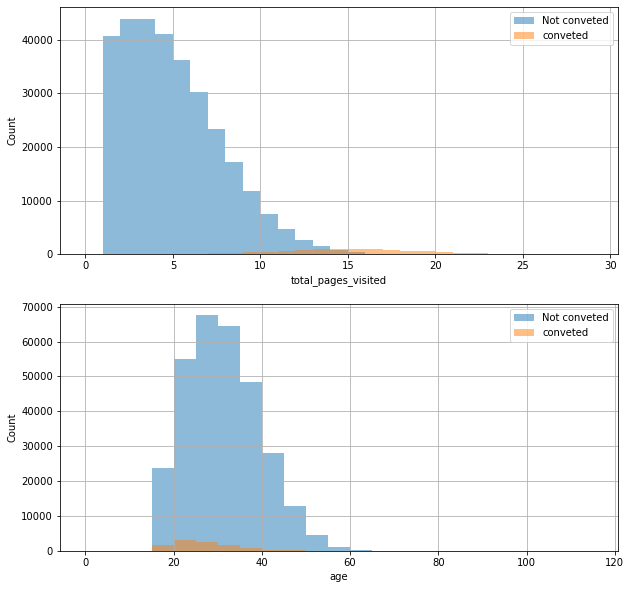

In [139]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))

# the histogram of the data
n, bins, patches = ax[0].hist(df[df.converted == 0][["total_pages_visited"]
                             ], bins=[1*i for i in range(30)], color = '#1f77b4', alpha=0.5, density=False, label="Not conveted")


n, bins, patches = ax[0].hist(df[df.converted == 1][["total_pages_visited"]
                             ], bins=[1*i for i in range(30)], color = '#ff7f0e', alpha=0.5, density=False, label="conveted")

ax[0].set_xlabel("total_pages_visited")
ax[0].set_ylabel("Count")
ax[0].legend()
ax[0].grid(True)

# the histogram of the data
n, bins, patches = ax[1].hist(df[df.converted == 0][["age"]
                             ], bins=[5*i for i in range(24)], color = '#1f77b4', alpha=0.5, density=False, label="Not conveted")

n, bins, patches = ax[1].hist(df[df.converted == 1][["age"]
                             ], bins=[5*i for i in range(24)], color = '#ff7f0e', alpha=0.5, density=False, label="conveted")

ax[1].set_xlabel("age")
ax[1].set_ylabel("Count")
ax[1].legend()
ax[1].grid(True)

- Overall
    - 瀏覽頁面的數量較多，越容易converted
    - 低年齡層，越容易converted

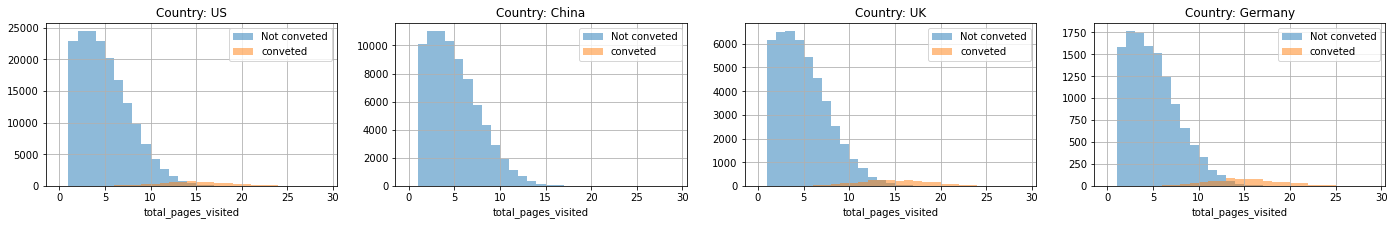

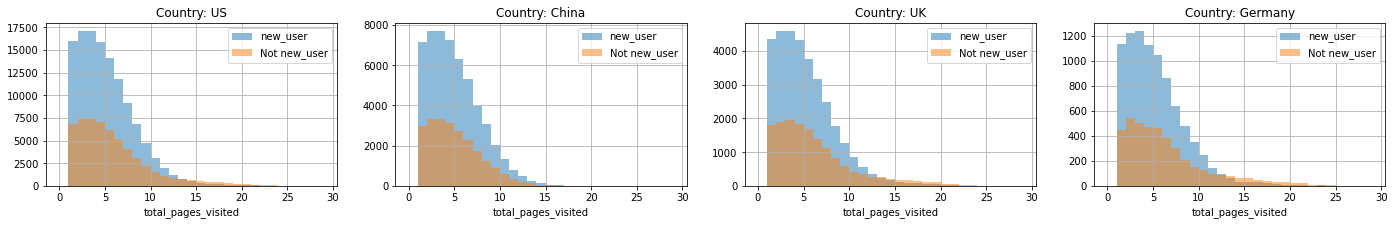

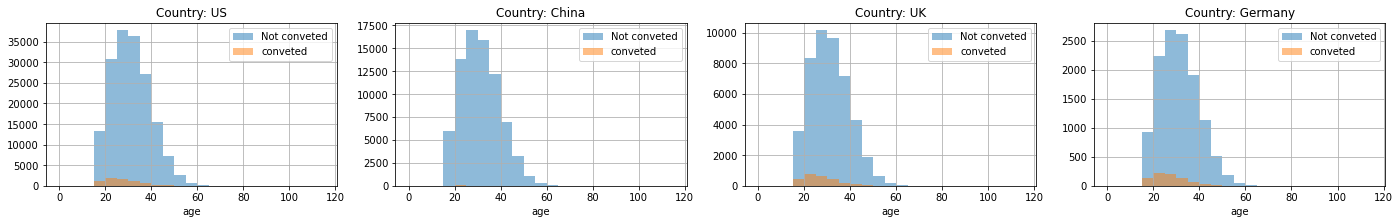

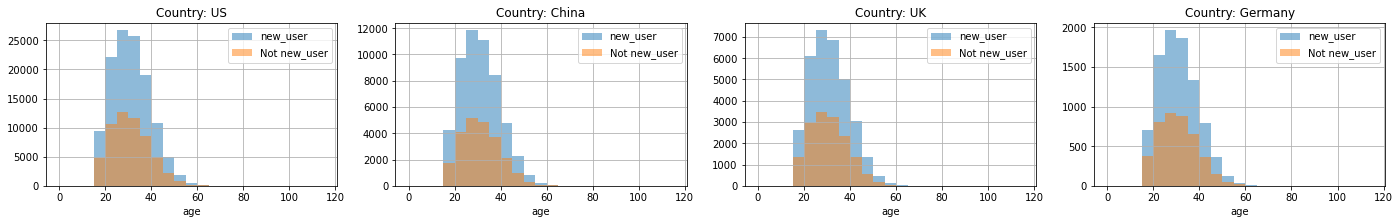

<Figure size 1440x864 with 0 Axes>

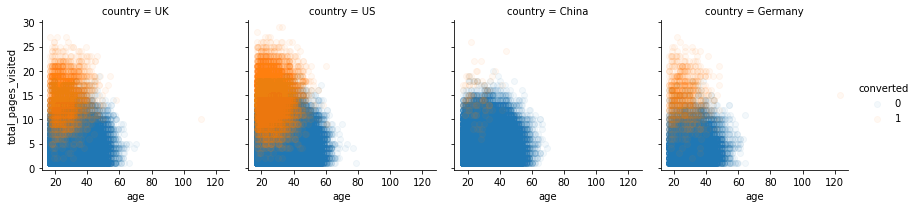

<Figure size 1440x864 with 0 Axes>

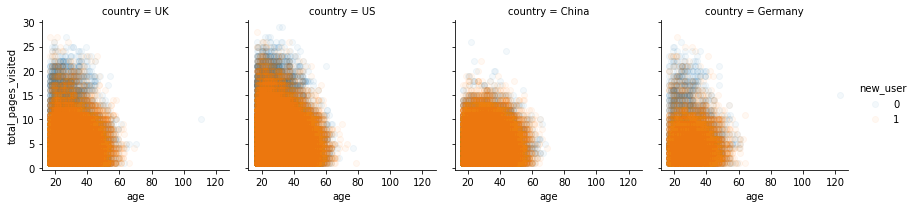

In [196]:
fig, ax = plt.subplots(1, 4, figsize=(6*4,3))
for i, c in enumerate(df.country.value_counts().index):
    # the histogram of the data
    n, bins, patches = ax[i].hist(df[(df.converted == 0)
                                    & (df.country == c)
                                    ][["total_pages_visited"]
                                 ], bins=[1*i for i in range(30)], color = '#1f77b4', alpha=0.5, density=False, label="Not conveted")


    n, bins, patches = ax[i].hist(df[(df.converted == 1)
                                    & (df.country == c)
                                    ][["total_pages_visited"]
                                 ], bins=[1*i for i in range(30)], color = '#ff7f0e', alpha=0.5, density=False, label="conveted")

    ax[i].set_title(f"Country: {c}")
    ax[i].set_xlabel("total_pages_visited")
    ax[i].legend()
    ax[i].grid(True)

fig, ax = plt.subplots(1, 4, figsize=(6*4,3))
for i, c in enumerate(df.country.value_counts().index):
    # the histogram of the data
    n, bins, patches = ax[i].hist(df[(df.new_user == 1)
                                    & (df.country == c)
                                    ][["total_pages_visited"]
                                 ], bins=[1*i for i in range(30)], color = '#1f77b4', alpha=0.5, density=False, label="new_user")

    n, bins, patches = ax[i].hist(df[(df.new_user == 0)
                                    & (df.country == c)
                                    ][["total_pages_visited"]
                                 ], bins=[1*i for i in range(30)], color = '#ff7f0e', alpha=0.5, density=False, label="Not new_user")

    ax[i].set_title(f"Country: {c}")
    ax[i].set_xlabel("total_pages_visited")
    ax[i].legend()
    ax[i].grid(True)

fig, ax = plt.subplots(1, 4, figsize=(6*4,3))
for i, c in enumerate(df.country.value_counts().index):
    # the histogram of the data
    n, bins, patches = ax[i].hist(df[(df.converted == 0)
                                    & (df.country == c)
                                    ][["age"]
                                 ], bins=[5*i for i in range(24)], color = '#1f77b4', alpha=0.5, density=False, label="Not conveted")


    n, bins, patches = ax[i].hist(df[(df.converted == 1)
                                    & (df.country == c)
                                    ][["age"]
                                 ], bins=[5*i for i in range(24)], color = '#ff7f0e', alpha=0.5, density=False, label="conveted")

    ax[i].set_title(f"Country: {c}")
    ax[i].set_xlabel("age")
    ax[i].legend()
    ax[i].grid(True)
    
fig, ax = plt.subplots(1, 4, figsize=(6*4,3))
for i, c in enumerate(df.country.value_counts().index):
    # the histogram of the data
    n, bins, patches = ax[i].hist(df[(df.new_user == 1)
                                    & (df.country == c)
                                    ][["age"]
                                 ], bins=[5*i for i in range(24)], color = '#1f77b4', alpha=0.5, density=False, label="new_user")

    n, bins, patches = ax[i].hist(df[(df.new_user == 0)
                                    & (df.country == c)
                                    ][["age"]
                                 ], bins=[5*i for i in range(24)], color = '#ff7f0e', alpha=0.5, density=False, label="Not new_user")

    ax[i].set_title(f"Country: {c}")
    ax[i].set_xlabel("age")
    ax[i].legend()
    ax[i].grid(True)
    
# age v.s. total_pages_visited v.s. converted
# 越往右上，Converted的趨勢越明顯
# UK, US, Germany 分布較相似
# China 的人購物比例較低

plt.figure(figsize=(20,12))
g = sns.FacetGrid(df, col="country",hue = 'converted')
g.map(plt.scatter, "age", "total_pages_visited", alpha=.05)
g.add_legend();

plt.figure(figsize=(20,12))
g = sns.FacetGrid(df, col="country",hue = 'new_user')
g.map(plt.scatter, "age", "total_pages_visited", alpha=.05)
g.add_legend();

### 分組觀察
- country v.s. total_pages_visited v.s. new_user v.s. converted
    - UK, US, Germany 分布較相似
    - China converted 比例明顯偏低
    - 各區域非新用戶瀏覽數量都較高
    - 高瀏覽的用戶 converted的比例也較多
- country v.s. age v.s. new_user v.s. converted
    - 較低年齡層，converted的比例也較多
    - 各國在新舊用戶的分布上很接近

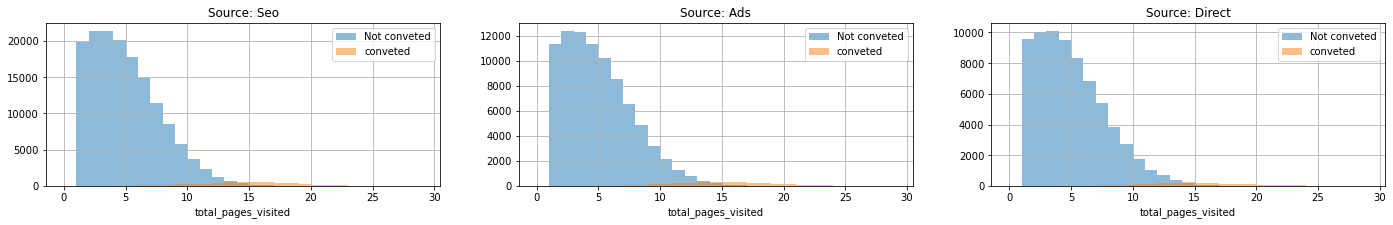

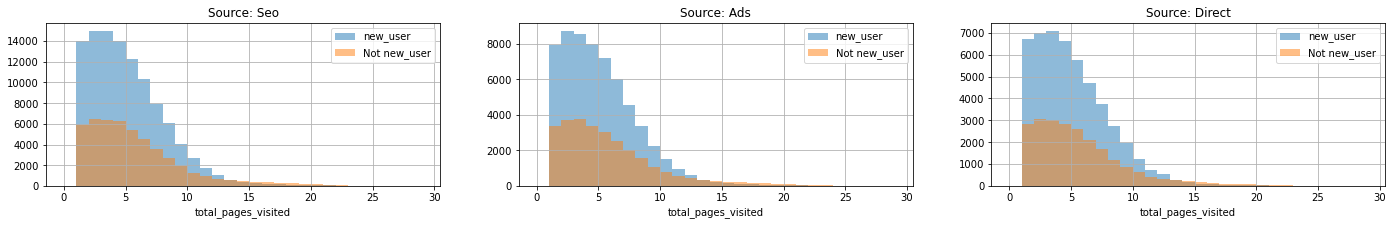

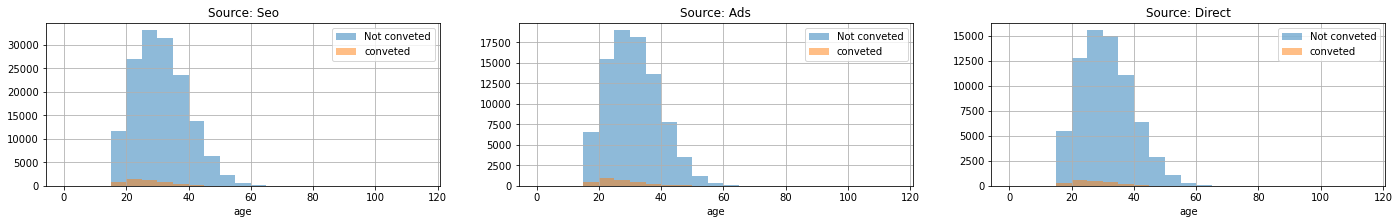

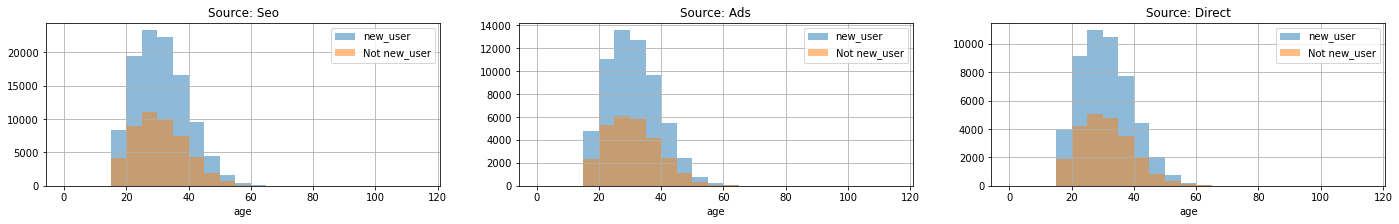

<Figure size 1440x864 with 0 Axes>

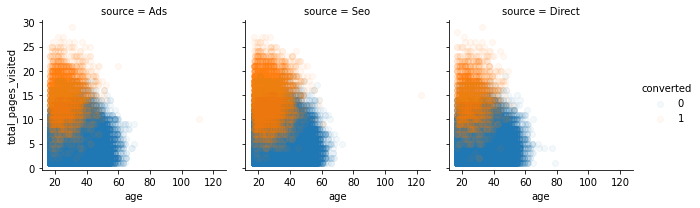

<Figure size 1440x864 with 0 Axes>

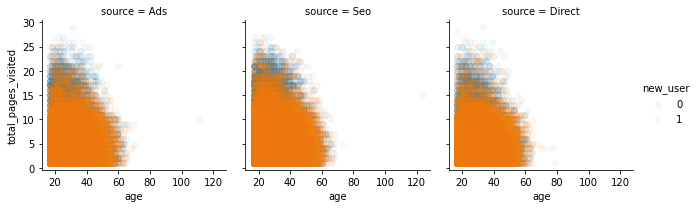

In [198]:
fig, ax = plt.subplots(1, 3, figsize=(8*3,3))
for i, c in enumerate(df.source.value_counts().index):
    # the histogram of the data
    n, bins, patches = ax[i].hist(df[(df.converted == 0)
                                    & (df.source == c)
                                    ][["total_pages_visited"]
                                 ], bins=[1*i for i in range(30)], color = '#1f77b4', alpha=0.5, density=False, label="Not conveted")


    n, bins, patches = ax[i].hist(df[(df.converted == 1)
                                    & (df.source == c)
                                    ][["total_pages_visited"]
                                 ], bins=[1*i for i in range(30)], color = '#ff7f0e', alpha=0.5, density=False, label="conveted")

    ax[i].set_title(f"Source: {c}")
    ax[i].set_xlabel("total_pages_visited")
    ax[i].legend()
    ax[i].grid(True)

fig, ax = plt.subplots(1, 3, figsize=(8*3,3))
for i, c in enumerate(df.source.value_counts().index):
    # the histogram of the data
    n, bins, patches = ax[i].hist(df[(df.new_user == 1)
                                    & (df.source == c)
                                    ][["total_pages_visited"]
                                 ], bins=[1*i for i in range(30)], color = '#1f77b4', alpha=0.5, density=False, label="new_user")

    n, bins, patches = ax[i].hist(df[(df.new_user == 0)
                                    & (df.source == c)
                                    ][["total_pages_visited"]
                                 ], bins=[1*i for i in range(30)], color = '#ff7f0e', alpha=0.5, density=False, label="Not new_user")

    ax[i].set_title(f"Source: {c}")
    ax[i].set_xlabel("total_pages_visited")
    ax[i].legend()
    ax[i].grid(True)
        
fig, ax = plt.subplots(1, 3, figsize=(8*3,3))
for i, c in enumerate(df.source.value_counts().index):
    # the histogram of the data
    n, bins, patches = ax[i].hist(df[(df.converted == 0)
                                    & (df.source == c)
                                    ][["age"]
                                 ], bins=[5*i for i in range(24)], color = '#1f77b4', alpha=0.5, density=False, label="Not conveted")


    n, bins, patches = ax[i].hist(df[(df.converted == 1)
                                    & (df.source == c)
                                    ][["age"]
                                 ], bins=[5*i for i in range(24)], color = '#ff7f0e', alpha=0.5, density=False, label="conveted")

    ax[i].set_title(f"Source: {c}")
    ax[i].set_xlabel("age")
    ax[i].legend()
    ax[i].grid(True)

fig, ax = plt.subplots(1, 3, figsize=(8*3,3))
for i, c in enumerate(df.source.value_counts().index):
    # the histogram of the data
    n, bins, patches = ax[i].hist(df[(df.new_user == 1)
                                    & (df.source == c)
                                    ][["age"]
                                 ], bins=[5*i for i in range(24)], color = '#1f77b4', alpha=0.5, density=False, label="new_user")

    n, bins, patches = ax[i].hist(df[(df.new_user == 0)
                                    & (df.source == c)
                                    ][["age"]
                                 ], bins=[5*i for i in range(24)], color = '#ff7f0e', alpha=0.5, density=False, label="Not new_user")

    ax[i].set_title(f"Source: {c}")
    ax[i].set_xlabel("age")
    ax[i].legend()
    ax[i].grid(True)

plt.figure(figsize=(20,12))
g = sns.FacetGrid(df, col="source",hue = 'converted')
g.map(plt.scatter, "age", "total_pages_visited", alpha=.05)
g.add_legend();

plt.figure(figsize=(20,12))
g = sns.FacetGrid(df, col="source",hue = 'new_user')
g.map(plt.scatter, "age", "total_pages_visited", alpha=.05)
g.add_legend();

- source v.s. total_pages_visited v.s. new_user v.s. converted
- source v.s. age v.s. new_user v.s. converted
    - 各個source的分佈差異不大

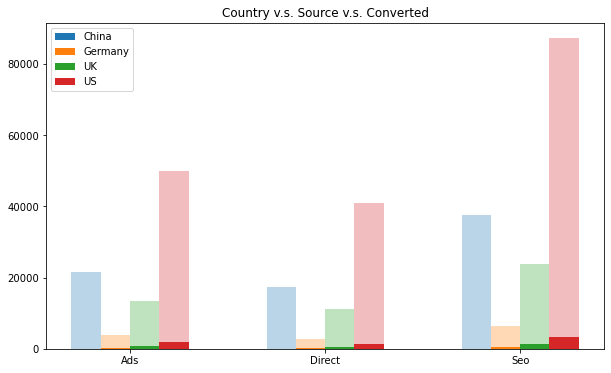

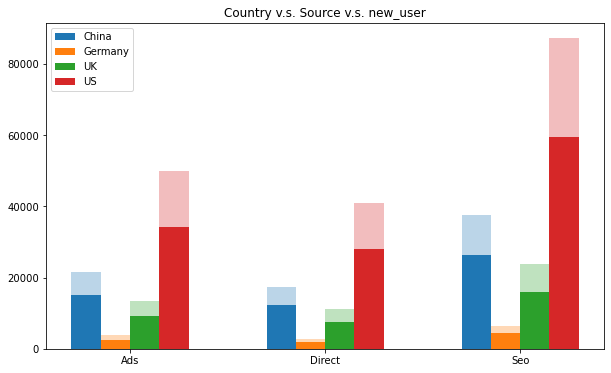

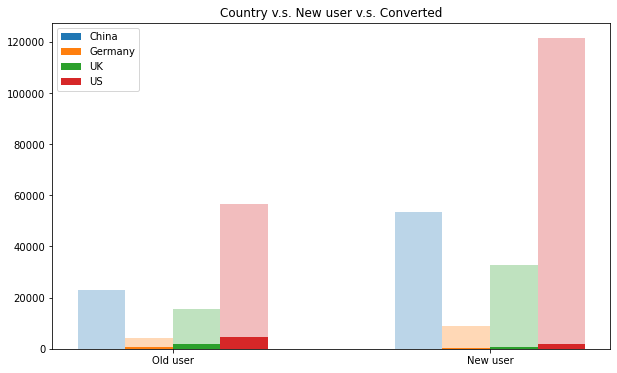

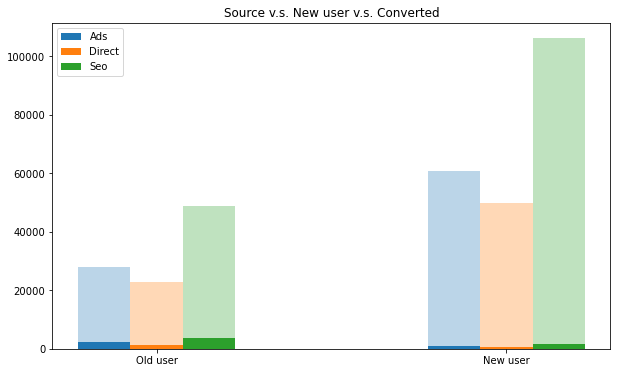

In [199]:
fig, ax = plt.subplots(figsize=(10,6))

country_list = df.groupby("country").count().iloc[:, 0].sort_index().index
source_list = df.groupby("source").count().iloc[:, 0].sort_index().index

total_counts = []
converted_counts = []
new_user_counts = []
for c in country_list:
    total_counts.append(df[df.country == c].groupby("source").count().iloc[:, 0].sort_index().values)
    converted_counts.append(df[(df.country == c)
                              & (df.converted == 1)
                              ].groupby("source").count().iloc[:, 0].sort_index().values)
    new_user_counts.append(df[(df.country == c)
                             & (df.new_user == 1)
                             ].groupby("source").count().iloc[:, 0].sort_index().values)

X = np.arange(3)
ax.bar(X - 0.15 - 0.075, np.array(total_counts)[0, :], color = '#1f77b4', width = 0.15, alpha=0.3)
ax.bar(X - 0.075, np.array(total_counts)[1, : ], color = '#ff7f0e', width = 0.15, alpha=0.3)
ax.bar(X + 0.15 - 0.075, np.array(total_counts)[2, :], color = '#2ca02c', width = 0.15, alpha=0.3)
ax.bar(X + 0.3 - 0.075, np.array(total_counts)[3, :], color = '#d62728', width = 0.15, alpha=0.3)

ax.bar(X - 0.15 - 0.075, np.array(converted_counts)[0, :], color = '#1f77b4', width = 0.15, label = country_list[0])
ax.bar(X - 0.075, np.array(converted_counts)[1, :], color = '#ff7f0e', width = 0.15, label = country_list[1])
ax.bar(X + 0.15 - 0.075, np.array(converted_counts)[2, :], color = '#2ca02c', width = 0.15, label = country_list[2])
ax.bar(X + 0.3 - 0.075, np.array(converted_counts)[3, :], color = '#d62728', width = 0.15, label = country_list[3])

ax.set_xticks(range(3))
ax.legend()
ax.set_title("Country v.s. Source v.s. Converted")
_ = ax.set_xticklabels(list(source_list))


fig, ax = plt.subplots(figsize=(10,6))
X = np.arange(3)
ax.bar(X - 0.15 - 0.075, np.array(total_counts)[0, :], color = '#1f77b4', width = 0.15, alpha=0.3)
ax.bar(X - 0.075, np.array(total_counts)[1, : ], color = '#ff7f0e', width = 0.15, alpha=0.3)
ax.bar(X + 0.15 - 0.075, np.array(total_counts)[2, :], color = '#2ca02c', width = 0.15, alpha=0.3)
ax.bar(X + 0.3 - 0.075, np.array(total_counts)[3, :], color = '#d62728', width = 0.15, alpha=0.3)

ax.bar(X - 0.15 - 0.075, np.array(new_user_counts)[0, :], color = '#1f77b4', width = 0.15, label = country_list[0])
ax.bar(X - 0.075, np.array(new_user_counts)[1, :], color = '#ff7f0e', width = 0.15, label = country_list[1])
ax.bar(X + 0.15 - 0.075, np.array(new_user_counts)[2, :], color = '#2ca02c', width = 0.15, label = country_list[2])
ax.bar(X + 0.3 - 0.075, np.array(new_user_counts)[3, :], color = '#d62728', width = 0.15, label = country_list[3])

ax.set_xticks(range(3))
ax.set_title("Country v.s. Source v.s. new_user")
ax.legend()
_ = ax.set_xticklabels(list(source_list))

fig, ax = plt.subplots(figsize=(10,6))

country_list = df.groupby("country").count().iloc[:, 0].sort_index().index
source_list = df.groupby("source").count().iloc[:, 0].sort_index().index

total_counts = []
converted_counts = []
for c in country_list:
    total_counts.append(df[df.country == c].groupby("new_user").count().iloc[:, 0].sort_index().values)
    converted_counts.append(df[(df.country == c)
                              & (df.converted == 1)
                              ].groupby("new_user").count().iloc[:, 0].sort_index().values)

X = np.arange(2)
ax.bar(X - 0.15 - 0.075, np.array(total_counts)[0, :], color = '#1f77b4', width = 0.15, alpha=0.3)
ax.bar(X - 0.075, np.array(total_counts)[1, : ], color = '#ff7f0e', width = 0.15, alpha=0.3)
ax.bar(X + 0.15 - 0.075, np.array(total_counts)[2, :], color = '#2ca02c', width = 0.15, alpha=0.3)
ax.bar(X + 0.3 - 0.075, np.array(total_counts)[3, :], color = '#d62728', width = 0.15, alpha=0.3)

ax.bar(X - 0.15 - 0.075, np.array(converted_counts)[0, :], color = '#1f77b4', width = 0.15, label = country_list[0])
ax.bar(X - 0.075, np.array(converted_counts)[1, :], color = '#ff7f0e', width = 0.15, label = country_list[1])
ax.bar(X + 0.15 - 0.075, np.array(converted_counts)[2, :], color = '#2ca02c', width = 0.15, label = country_list[2])
ax.bar(X + 0.3 - 0.075, np.array(converted_counts)[3, :], color = '#d62728', width = 0.15, label = country_list[3])

ax.set_xticks(range(2))
ax.legend()
ax.set_title("Country v.s. New user v.s. Converted")
_ = ax.set_xticklabels(["Old user", "New user"])

fig, ax = plt.subplots(figsize=(10,6))

# country_list = df.groupby("country").count().iloc[:, 0].sort_index().index
source_list = df.groupby("source").count().iloc[:, 0].sort_index().index

total_counts = []
converted_counts = []
for c in source_list:
    total_counts.append(df[df.source == c].groupby("new_user").count().iloc[:, 0].sort_index().values)
    converted_counts.append(df[(df.source == c)
                              & (df.converted == 1)
                              ].groupby("new_user").count().iloc[:, 0].sort_index().values)

X = np.arange(2)
ax.bar(X - 0.15, np.array(total_counts)[0, :], color = '#1f77b4', width = 0.15, alpha=0.3)
ax.bar(X , np.array(total_counts)[1, : ], color = '#ff7f0e', width = 0.15, alpha=0.3)
ax.bar(X + 0.15, np.array(total_counts)[2, :], color = '#2ca02c', width = 0.15, alpha=0.3)
# ax.bar(X + 0.3 - 0.075, np.array(total_counts)[3, :], color = '#d62728', width = 0.15, alpha=0.3)

ax.bar(X - 0.15 , np.array(converted_counts)[0, :], color = '#1f77b4', width = 0.15, label = source_list[0])
ax.bar(X, np.array(converted_counts)[1, :], color = '#ff7f0e', width = 0.15, label = source_list[1])
ax.bar(X + 0.15, np.array(converted_counts)[2, :], color = '#2ca02c', width = 0.15, label = source_list[2])
# ax.bar(X + 0.3 - 0.075, np.array(converted_counts)[3, :], color = '#d62728', width = 0.15, label = country_list[3])

ax.set_xticks(range(2))
ax.legend()
ax.set_title("Source v.s. New user v.s. Converted")
_ = ax.set_xticklabels(["Old user", "New user"])


- country v.s. source v.s. new_user v.s. converted
    - 雖然US人數較多，但整體converted的比例都偏低
    - Seo 的比例雖然最高，但converted的比例也都偏低
    - 舊用戶各種方式進來的，converted比例都較新用戶高
    - 各區域新舊用戶的比例沒有差很多

# Summary

### Description
- Shape: (316200, 6)
- conveted: target
    - Binary
    - Not conveted:converted 大約 30:1
    - unbalaned data
- new_user:
    - Binary
    - Not new user:new_user大約 3:7
- country
    - Categorical variable (UK, US, China, Germany)
    - 以US佔大多數，約56% (其次China:24%, UK:15%, Germany:4%)
- source
    - Categorical variable (Ads, Seo, Direct)
    - 以Seo，約49% (其次Ads:28%, Direct:22%)
- Age
    - Continuous variable (min=17, max=123)
    - 大多數用戶介於 20~40之間 (q1=24, q2=30, q3=36)
    - 用戶屬於年輕人居多
    - 右尾分布
    - 有兩個異常值，需做處理
- total_pages_visited
    - Continuous variable (min=1, max=29)
    - 大多數用戶介於 1~10之間 (q1=2, q2=4, q3=7)
    - 大多數用戶停留時間不長（不會瀏覽太多頁面
    - 右尾分布
    

### Insights

- 與Converted的關係
    - total_pages_visited (中度正相關)：瀏覽的網頁數越多，越有機會converted
    - new_user (低度負相關)：新用戶較不容易converted
    - age, is_China (接近低度負相關)
- 可能會converted的人
    - 瀏覽頁面的數量較多
    - 低年齡層
- country v.s. total_pages_visited v.s. new_user v.s. converted
    - UK, US, Germany 分布較相似
    - China converted 比例明顯偏低
    - 各區域非新用戶瀏覽數量都較高
    - 高瀏覽的用戶 converted的比例也較多
- country v.s. age v.s. new_user v.s. converted
    - 較低年齡層，converted的比例也較多
    - 各國在新舊用戶的分布上很接近
- source v.s. total_pages_visited v.s. new_user v.s. converted
- source v.s. age v.s. new_user v.s. converted
    - 各個source的分佈差異不大
- country v.s. source v.s. new_user v.s. converted
    - 雖然US人數較多，但整體converted的比例都偏低
    - Seo 的比例雖然最高，但converted的比例也都偏低
    - 舊用戶各種方式進來的，converted比例都較新用戶高
    - 各區域新舊用戶的比例沒有差很多

## Reference:
- Visualization Ref: https://www.kaggle.com/code/gaurangthakur/sales-conversion-optimization-xgboost
- Pandas-profiling: https://www.learncodewithmike.com/2021/07/pandas-profiling.html
- Categorical Encoding: https://ithelp.ithome.com.tw/articles/10233484